Create a tiny dask array with random integers and examine the underlying graph structure:

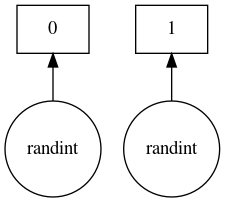

In [1]:
import dask.array as da
da.random.randint(0,255, size=(2,), chunks=(1,)).visualize()

Changing the *chunking* of the array alters the task graph:

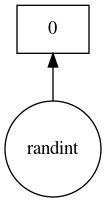

In [2]:
da.random.randint(0,255, size=(2,), chunks=(2,)).visualize()

Dask arrays are lazy, so "creating" a dask array == creating a list of tasks.   
E.g., here I create a 64 GB dask array (on a laptop with 8 GB of RAM):

In [3]:
arr_big = da.random.randint(0, 255, size= 3 * (2000,), chunks= 3 * (250,))
arr_big

dask.array<randint, shape=(2000, 2000, 2000), dtype=int64, chunksize=(250, 250, 250), chunktype=numpy.ndarray>

Indexing this array returns another dask array, not data:

In [4]:
arr_big[0,0,:]

dask.array<getitem, shape=(2000,), dtype=int64, chunksize=(250,), chunktype=numpy.ndarray>

The `compute` method gets actual values out of the array. 

In [5]:
print(arr_big[0,0,:].compute())

[ 77 221 137 ...  34  87  20]


Arithmetic operators and broadcasting work in the numpy style:

In [6]:
arr_small = da.random.randint(0, 255, size= (4,), chunks= (1,))
mn, mx = arr_small.min(), arr_small.max()
rescaled = (arr_small - mn) / (mx - mn)
rescaled

dask.array<truediv, shape=(4,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>

In [7]:
rescaled.visualize(optimize_graph=True, filename='normalize.png');

#### Real-life example 
Processing a TB-scale FIB-SEM dataset that lives on disk as a list of thousands of files.  
Using 10 cluster nodes in an interactive session: `bsub -ISs -n10 /bin/bash`

In [8]:
from fst.io import read # a function that reads in a single file
from glob import glob
dataset_name = 'Macrophage_FS80_Cell2_4x4x4nm'
fnames = sorted(glob(f'/groups/cosem/cosem/data/{dataset_name}/raw/*.dat'))
sample = read(fnames[0])
print('Shape:', len(fnames), *sample.shape)

Shape: 11087 2 2500 10000


* `dask.delayed`: takes a function; returns a lazy version of that function. 
* `dask.array.from_delayed`: takes a lazy function, args; returns a dask array
* `dask.array.stack`: combine dask arrays along a new axis

In [9]:
%%time
from dask import delayed
#The resulting function doesn't touch the filesystem until `compute` is called.
lazy_read = delayed(read)

lazy_dataset = (da.from_delayed(lazy_read(f), dtype=sample.dtype, shape=sample.shape) for f in fnames)
dataset = da.stack(lazy_dataset)
dataset

CPU times: user 7.26 s, sys: 228 ms, total: 7.49 s
Wall time: 7.31 s


,Array,Chunk
Bytes,1.11 TB,100.00 MB
Shape,"(11087, 2, 2500, 10000)","(1, 2, 2500, 10000)"
Count,44348 Tasks,11087 Chunks
Type,int16,numpy.ndarray


3D indexing of a list-of-files:

In [10]:
%%time
import numpy as np

# 100x100x100 cube of data
z, y, x = slice(100), slice(100), slice(100)

# This outer loop will run serially :(
res_np = np.array([read(f) for f in fnames[z]])[0, y, x]

CPU times: user 3.87 s, sys: 4.1 s, total: 7.97 s
Wall time: 8.01 s


3D indexing of a dask array:

In [11]:
%%time
# The (now hidden) outer loop is parallelized
res_da = dataset[z,0,y,x].compute()

CPU times: user 6.39 s, sys: 29.4 s, total: 35.8 s
Wall time: 3.41 s


`compute` takes a `scheduler` argument, which determines how the task graph gets computed.  
There are two "local" schedulers:

In [12]:
dataset[0].compute(scheduler='threads') # local threaded scheduler
dataset[0].compute(scheduler='processes'); # local multiprocessing scheduler

And, via the `dask-distributed` project, a more robust distributed scheduler:

In [12]:
from distributed import Client, LocalCluster
cl_local = Client(LocalCluster(dashboard_address=':0')) # create a "local cluster" 
dataset[0].compute(); # the distributed scheduler registers itself as default

from fst.distributed import get_jobqueue_cluster
cl_janelia = Client(get_jobqueue_cluster(dashboard_address=':0'))

Like spark, `dask-distributed` has a useful web dashboard.

In [13]:
cl_janelia

Client Scheduler: tcp://10.36.111.12:32877 Dashboard: http://10.36.111.12:35035/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


Workers can be added and removed as needed:

In [14]:
%%time
cl_janelia.cluster.scale(200)
dataset.mean().compute() # take the mean of the entire 1.11 TB dataset
cl_janelia.cluster.scale(0)

CPU times: user 1min 41s, sys: 11.8 s, total: 1min 53s
Wall time: 3min 38s


#### A typical application: Image registration for a massive dataset.  
First, define a (lazy) function that maps pairs of images to a transform:

In [15]:
@delayed # use the `delayed` function as a decorator
def align(arr1, arr2):
    from skimage.feature import register_translation
    from scipy.ndimage.filters import gaussian_filter
    gauf = lambda v: gaussian_filter(v, sigma=2.0)
    return register_translation(gauf(arr1.astype('float32')), gauf(arr2.astype('float32')), return_error=False)

Recruit some workers and run the registration function over the first 100 pairs of images:

In [19]:
%%time

z_range = np.arange(100) # process 100 pairs of images

cl_janelia.cluster.scale(20) # get 20 workers
transforms = (align(dataset[z,0], dataset[z+1,0]) for z in z_range)
results = np.array(da.compute(*transforms))
cl_janelia.cluster.scale(0) # release workers

sample = dataset[z_range, 0].compute(scheduler='threads') # take some data for visualization later

CPU times: user 20.3 s, sys: 31.9 s, total: 52.1 s
Wall time: 36.4 s


Visualize the results:

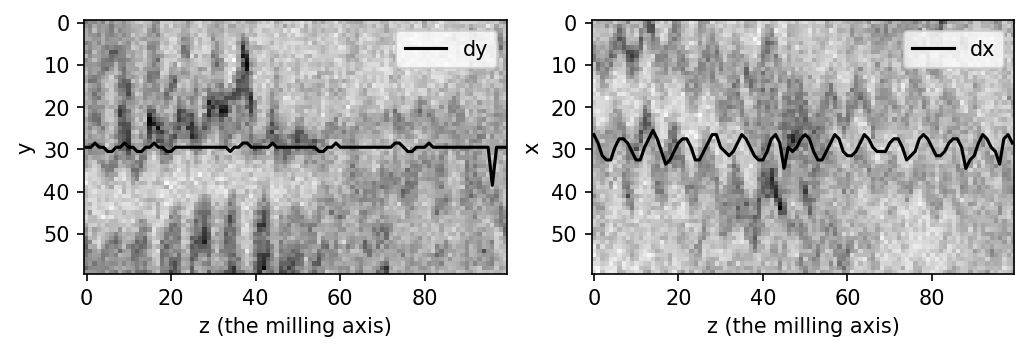

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
dims = 'z','y','x'
span = np.arange(-30,30)
x,y = 1530,530
fig, axs = plt.subplots(ncols=2, dpi=150, figsize=(8,4))
axs[0].imshow(sample[:, y + span, x].T, cmap='gray_r')
axs[1].imshow(sample[:, y, x + span].T, cmap='gray_r')
for ind,ax in enumerate(axs):
    ax.plot(results[:,ind] + span.ptp()/2, color='k', label=f'd{dims[ind + 1]}')    
    ax.set_xlabel(f'{dims[0]} (the milling axis)')
    ax.set_ylabel(dims[1 + ind])
    ax.legend()

Be careful when using `da.from_array with a numpy array:

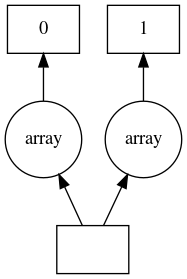

In [27]:
da.from_array(np.zeros(2), chunks=(1,)).visualize()

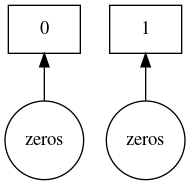

In [26]:
da.zeros(2, chunks=(1,)).visualize()